<a href="https://colab.research.google.com/github/martadorozh/TweeterAnalysis/blob/main/TweetsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter data Analysis & BTC Price Prediction **

---

---

Co z stopwords i tokenizacja 
UWAGI : czy robic oddzielnie bigramy i sentyment analysis czy w jednym pliku? + dodac opis i wszystko poukladac porzadnie. Czy biblioteki razom na poczatku czy do koznogo okremo
\


## Introduction

> A quite specific problem related to the classification of a text is the recognition of its overtone, the so-called sentiment analysis. It is especially important when, for example, we want to catch these negative entries in social media and react to them. In a broader spectrum, we would like to recognize emotions, but in simpler cases, we agree to recognize classes: positive / negative / neutral or of a wider spectrum, e.g. very negative. It depends on how we formulate the problem and how accurately we are able to label the data.



### **Module Imports**


In [1]:
import pandas as pd
import nltk
import re

At this point all tweets have been collected using twitters api and TweePy library, saved as a csv file. In total 92488 raw tweets were collected from 01/04/2022 to 04/07/2022. Tweets were collected only in english language. In addition to the raw tweets, attributes such as the timestamp of the tweet, number of times the tweet was favorited and the number of followers and retweets of the tweet were collected to later investigate the impact they may on BTC price.

### **Loading Tweets**

In [2]:
tweets = pd.read_csv('tweets.csv')

### **Data preprocessing**

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92489 entries, 0 to 92488
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   field1                 92488 non-null  float64
 1   text                   92488 non-null  object 
 2   retweet_count          92488 non-null  float64
 3   created_at             92488 non-null  object 
 4   favorite_count         92488 non-null  float64
 5   user.screen_name       92488 non-null  object 
 6   user.listed_count      92488 non-null  float64
 7   user.utc_offset        0 non-null      float64
 8   user.favourites_count  92488 non-null  float64
 9   user.followers_count   92488 non-null  float64
 10  user.created_at        92488 non-null  object 
 11  user.description       78521 non-null  object 
dtypes: float64(7), object(5)
memory usage: 8.5+ MB


In [5]:
# Check empty observation 
tweets.text.isna().sum()

1

In [4]:
# Droping non useful columns
tweets = tweets.drop(columns=['user.utc_offset', 'field1'])

In [6]:
tweets.head()

,text,retweet_count,created_at,favorite_count,user.screen_name,user.listed_count,user.favourites_count,user.followers_count,user.created_at,user.description
0,"BOT by UpTrend GOLD M15 at 1924.73\nApril 02, ...",0.0,2022-04-01 18:30:06,0.0,pitopitomm,24.0,97341.0,3509.0,2010-05-16 00:20:57,GOLD(#XAUUSD)とBTC(#BTC)メインの兼業トレーダー｜経営者｜ひとりごと＋B...
1,Just In Crypto: $BTC #BITCOIN Bitcoin Spot ETF...,0.0,2022-04-01 18:30:06,0.0,CWireNews,2.0,1.0,898.0,2021-09-06 17:01:46,Crypto Wire News is a platform for the crypto ...
2,🔰#MIRUtoken #MIRU $MIRU #BNB $MIRU 🔥 #MIRU ...,0.0,2022-04-01 18:30:05,0.0,Mohsen94940,1.0,115.0,15.0,2018-12-31 09:41:45,NaN
3,#Bitcoin price in US Dollar #BTC $usd #BTCUSD ...,0.0,2022-04-01 18:30:04,0.0,BTCtoCAD,9.0,671.0,328.0,2020-07-29 01:50:02,#Bitcoin Is King 👑\nBitcoin Price Converter fo...
4,"Manchester City vs. Burnley prediction, odds, ...",0.0,2022-04-01 18:30:03,0.0,BetFastcom,57.0,1715.0,11074.0,2013-11-04 07:15:04,Providing real-time wagering information on up...


In [7]:
tweets['text']=tweets['text'].apply(str)

### **Data Cleaning**

In [8]:
# Remove the content of `RT @name:`, which is at the beginning of the retweets
regex = re.compile(r"^RT @.*:\s")

tweets.text = tweets.text.apply(lambda x: re.sub(regex, "", x))

In [9]:
# Remove all mentions of users in the content
regex = r"\B@\w+"

tweets.text = tweets.text.apply(lambda x: re.sub(regex, "", x))

# Remove some special characters
tweets.text = tweets.text.str.replace("#", "")
tweets.text = tweets.text.str.replace("…", "")
tweets.text = tweets.text.str.replace("•", "")

In [10]:
# Remove urls from tweets
regex = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"

tweets.text = tweets.text.apply(lambda x: re.sub(regex, "", x))

In [11]:
# Replace the division of lines with spaces
tweets.text = tweets.text.str.replace("\n", " ")

In [12]:
# Remove emoji and other special characters
regex = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
    "]+",
    flags=re.UNICODE
)
tweets.text = tweets.text.apply(lambda x: re.sub(regex, "", x))

In [13]:
# Remove the punctuation
from string import punctuation

tweets.text = tweets.text.str.lower()
tweets.text = tweets.text.apply(lambda x: x.translate(str.maketrans("", "", punctuation))) # translate() i maketrans() sprawiają że działa szybciej

In [14]:
# Remove the lines in which after our cleaning
# nothing left in the text field (e.g. only spaces)
regex = r"^\s*$"

tweets = tweets[~tweets.text.str.contains(regex)]

In [15]:
#Checking if there any empty fields 
tweets.text.isna().sum()

0

In [16]:
tweets.tail()

,text,retweet_count,created_at,favorite_count,user.screen_name,user.listed_count,user.favourites_count,user.followers_count,user.created_at,user.description
92484,just in bitcoin is my preferred form of money...,0.0,2022-06-08 15:59:00,11.0,John_Jacob12,76.0,17.0,65157.0,2013-06-26 02:24:50,"#Bitcoin - There Is No Alternative | ""There ar..."
92485,someones been working hard bitcoin eth btc e...,0.0,2022-06-19 22:58:39,8.0,thejoshbarton,87.0,345.0,986.0,2014-11-19 18:38:17,A little Bitcoin in the morning makes you feel...
92486,while everyone is freaking out about backing ...,0.0,2022-06-20 22:58:39,3.0,TheBlockTake,753.0,35.0,987.0,2021-03-11 20:15:25,NFT Community. DM for Business $AVAX $ETH $SOL...
92487,elon musk was sued for 258bn on thursday by a ...,0.0,2022-06-21 22:58:39,15.0,realBitcoinDog,8.0,3.0,87.0,2013-06-26 02:24:50,#VC | No. 1 #Fintech @Refinitiv & @Onalytica |...
92488,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **STOPWORDS**

In [17]:
# Import stopwords
from nltk.corpus import stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### **Generate Bi-GRAMY**

In [19]:
#first do tokenization and removing
# Define a function for removing stopwords and generating bigrams
def generate_bigrams(text):
    words = [word for word in text.split() if word not in set(stopwords.words("english"))]
    ngrams = tuple(" ".join(x) for x in nltk.ngrams(words, 2))
    return ngrams
# The function returns a tuple with bigrames as text strings

In [20]:
# Testing
generate_bigrams("i like very much programming in python")

('like much', 'much programming', 'programming python')

In [22]:
# Create a new column with bigrams
# Use function
# It may take some time
tweets["bigrams"] = tweets.text.apply(generate_bigrams)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92352 entries, 0 to 92488
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   text                   92352 non-null  object 
 1   retweet_count          92351 non-null  float64
 2   created_at             92351 non-null  object 
 3   favorite_count         92351 non-null  float64
 4   user.screen_name       92351 non-null  object 
 5   user.listed_count      92351 non-null  float64
 6   user.favourites_count  92351 non-null  float64
 7   user.followers_count   92351 non-null  float64
 8   user.created_at        92351 non-null  object 
 9   user.description       78399 non-null  object 
 10  bigrams                92352 non-null  object 
dtypes: float64(5), object(6)
memory usage: 8.5+ MB


In [23]:
tweets.bigrams

0        (bot uptrend, uptrend gold, gold m15, m15 1924...
1        (crypto btc, btc bitcoin, bitcoin bitcoin, bit...
2        (mirutoken miru, miru miru, miru bnb, bnb miru...
3        (bitcoin price, price us, us dollar, dollar bt...
4        (manchester city, city vs, vs burnley, burnley...
                               ...                        
92484    (bitcoin preferred, preferred form, form money...
92485    (someones working, working hard, hard bitcoin,...
92486    (everyone freaking, freaking backing, backing ...
92487    (elon musk, musk sued, sued 258bn, 258bn thurs...
92488                                                   ()
Name: bigrams, Length: 92352, dtype: object

In [24]:
tweets.head()

,text,retweet_count,created_at,favorite_count,user.screen_name,user.listed_count,user.favourites_count,user.followers_count,user.created_at,user.description,bigrams
0,bot by uptrend gold m15 at 192473 april 02 202...,0.0,2022-04-01 18:30:06,0.0,pitopitomm,24.0,97341.0,3509.0,2010-05-16 00:20:57,GOLD(#XAUUSD)とBTC(#BTC)メインの兼業トレーダー｜経営者｜ひとりごと＋B...,"(bot uptrend, uptrend gold, gold m15, m15 1924..."
1,just in crypto btc bitcoin bitcoin spot etf im...,0.0,2022-04-01 18:30:06,0.0,CWireNews,2.0,1.0,898.0,2021-09-06 17:01:46,Crypto Wire News is a platform for the crypto ...,"(crypto btc, btc bitcoin, bitcoin bitcoin, bit..."
2,mirutoken miru miru bnb miru miru bsc bt...,0.0,2022-04-01 18:30:05,0.0,Mohsen94940,1.0,115.0,15.0,2018-12-31 09:41:45,NaN,"(mirutoken miru, miru miru, miru bnb, bnb miru..."
3,bitcoin price in us dollar btc usd btcusd xbt ...,0.0,2022-04-01 18:30:04,0.0,BTCtoCAD,9.0,671.0,328.0,2020-07-29 01:50:02,#Bitcoin Is King 👑\nBitcoin Price Converter fo...,"(bitcoin price, price us, us dollar, dollar bt..."
4,manchester city vs burnley prediction odds lin...,0.0,2022-04-01 18:30:03,0.0,BetFastcom,57.0,1715.0,11074.0,2013-11-04 07:15:04,Providing real-time wagering information on up...,"(manchester city, city vs, vs burnley, burnley..."


In [25]:
#Count bigrams and check which were the most popular
#For this was used the Counter object built into Python from the collections library
from collections import Counter

bigram_count = Counter([x for y in tweets.bigrams for x in y])

In [26]:
#Most popular biggrams
bigram_count.most_common(20)

[('bitcoin btc', 4633),
 ('btc bitcoin', 2664),
 ('bitcoin crypto', 2243),
 ('crypto bitcoin', 2169),
 ('bitcoin ethereum', 2017),
 ('found bitcoin', 1501),
 ('last price', 1492),
 ('bitcoin mining', 1458),
 ('join playing', 1419),
 ('vault location', 1418),
 ('playing coinhuntworld', 1418),
 ('coinhuntworld awesome', 1416),
 ('location join', 1411),
 ('awesome cryptocurrency', 1387),
 ('ethereum bitcoin', 1377),
 ('bitcoin price', 1358),
 ('buy bitcoin', 1304),
 ('one lucky', 1289),
 ('lucky follower', 1264),
 ('btc crypto', 1264)]

### **Plot**

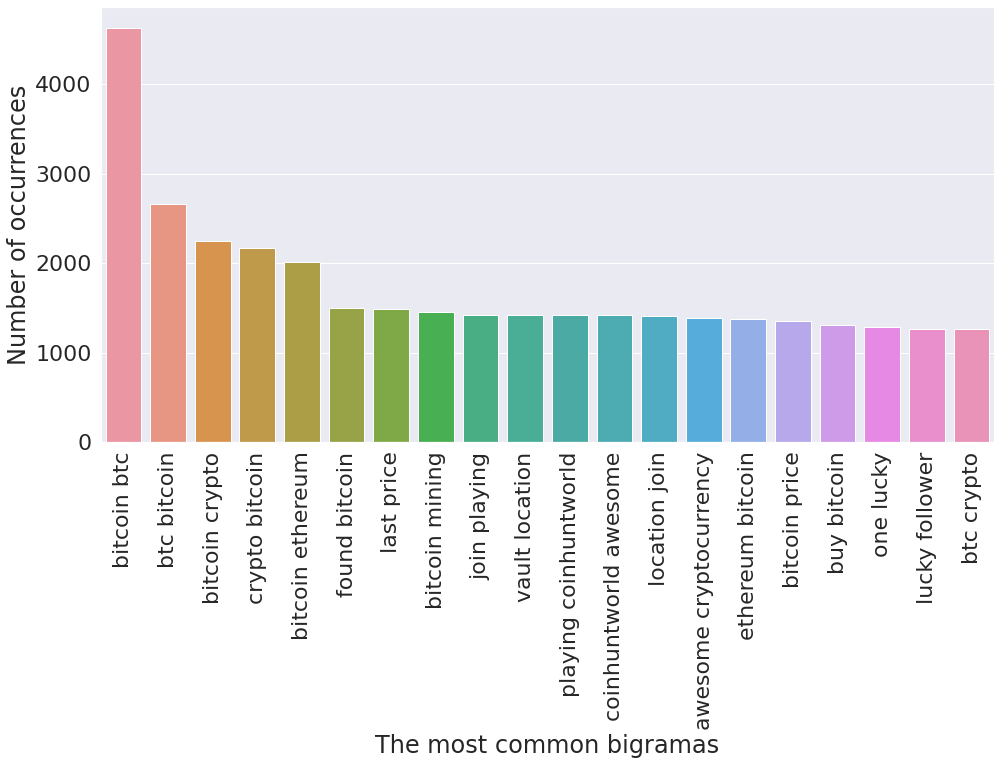

In [27]:
#Plot it
import seaborn
import matplotlib.pylab as plt

common = dict(bigram_count.most_common(20))

# Font size, chart size, and x axis label rotation
seaborn.set_theme(font_scale=2)
plt.figure(figsize=(16,8))
plt.xticks(rotation = 90)

plot = seaborn.barplot(
    x = 0,
    y = 1,
    data = pd.DataFrame(common.items())
)
plot.set(
    xlabel = "The most common bigramas",
    ylabel = "Number of occurrences"
)
plt.show()

In [28]:
# selecting bi-grams for the most liked (top 1000) tweets
# This time I'm using a comprehension list, not a loop
most_fav_bigrams = Counter([x for y in tweets.sort_values("favorite_count", ascending=False).head(1000).bigrams for x in y])

In [29]:
most_fav_bigrams.most_common(10)

[('bitcoin crypto', 38),
 ('bull run', 28),
 ('bitcoin btc', 26),
 ('btc crypto', 23),
 ('bitcoin ethereum', 22),
 ('btc bitcoin', 22),
 ('bear market', 21),
 ('bitcoin mining', 19),
 ('el salvador', 16),
 ('crypto bitcoin', 15)]

In [30]:
# Now the least liked
least_fav_bigrams = Counter([x for y in tweets.sort_values("favorite_count", ascending=True).head(1000).bigrams for x in y])
least_fav_bigrams.most_common(10)

[('24 hours', 280),
 ('hours follow', 268),
 ('people like', 267),
 ('like rt', 267),
 ('rt tweet', 267),
 ('tweet within', 267),
 ('within 24', 267),
 ('follow account', 267),
 ('account get', 267),
 ('get chance', 267)]

### **Sentiment Analysis**

For sentiment analysis was used VaderSentiment method.


> VaderSentiment is a lexicon, rules-based model for sentiment analysis.
Can efficiently handle vocabulary, abbreviations, capital letters, repeated punctuation marks, emoticons (😢, 😃, 😭, etc.), etc., which are usually adopted on social media platforms to express sentiment, making it great for sentiment text analysis on social media.


\
As a result of this method, we get 4 different results. The * neg *, * neu * and * pos * metrics are successively the probabilities of belonging to particular classes (negative, neutral and positive). The word * compound * is a unified measure that ranges from $ -1 $ to $ 1 $, where $ -1 $ is extremely negative and $ 1 $ is maximally positive. Therefore, we can treat it as a single measure and determine how positive a given entry is by setting an appropriate threshold. Typical thresholds are as follows:




- $ compound <= -0.05 $ - negative 
- $ -0.05 <compound <0.05 $ - neutral 
- $ compound> = 0.05 $ - positive 


In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
#Tokenization and stopwords removing from text
def data_processing(text):
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stopwords.words("english")]
    return " ".join(filtered_text)

In [36]:
#May take some time 
tweets.text = tweets['text'].apply(data_processing)

In [37]:
tweets.tail()

,text,retweet_count,created_at,favorite_count,user.screen_name,user.listed_count,user.favourites_count,user.followers_count,user.created_at,user.description,bigrams
92484,bitcoin preferred form money since 2013 us sen...,0.0,2022-06-08 15:59:00,11.0,John_Jacob12,76.0,17.0,65157.0,2013-06-26 02:24:50,"#Bitcoin - There Is No Alternative | ""There ar...","(bitcoin preferred, preferred form, form money..."
92485,someones working hard bitcoin eth btc ethereum...,0.0,2022-06-19 22:58:39,8.0,thejoshbarton,87.0,345.0,986.0,2014-11-19 18:38:17,A little Bitcoin in the morning makes you feel...,"(someones working, working hard, hard bitcoin,..."
92486,everyone freaking backing id company someone p...,0.0,2022-06-20 22:58:39,3.0,TheBlockTake,753.0,35.0,987.0,2021-03-11 20:15:25,NFT Community. DM for Business $AVAX $ETH $SOL...,"(everyone freaking, freaking backing, backing ..."
92487,elon musk sued 258bn thursday dogecoin investo...,0.0,2022-06-21 22:58:39,15.0,realBitcoinDog,8.0,3.0,87.0,2013-06-26 02:24:50,#VC | No. 1 #Fintech @Refinitiv & @Onalytica |...,"(elon musk, musk sued, sued 258bn, 258bn thurs..."
92488,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,()


### **Import BTC data**

In [38]:
btc = pd.read_csv('btc.csv')

# Printing out the first 5 rows of the dataframe
btc.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 04, 2022","20,224.0","19,308.8","20,318.0","19,056.6",3.55K,4.74%
1,"Jul 03, 2022","19,308.8","19,230.0","19,638.0","18,774.0",2.35K,0.41%
2,"Jul 02, 2022","19,230.0","19,286.0","19,442.0","18,994.0",1.67K,-0.29%
3,"Jul 01, 2022","19,286.0","19,938.0","20,795.0","18,993.0",5.19K,-3.27%
4,"Jun 30, 2022","19,938.0","20,106.6","20,146.1","18,643.0",5.75K,-0.84%


In [39]:
btc["Change %"] = btc["Change %"].str.replace("%", "")

In [40]:
btc.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 04, 2022","20,224.0","19,308.8","20,318.0","19,056.6",3.55K,4.74
1,"Jul 03, 2022","19,308.8","19,230.0","19,638.0","18,774.0",2.35K,0.41
2,"Jul 02, 2022","19,230.0","19,286.0","19,442.0","18,994.0",1.67K,-0.29
3,"Jul 01, 2022","19,286.0","19,938.0","20,795.0","18,993.0",5.19K,-3.27
4,"Jun 30, 2022","19,938.0","20,106.6","20,146.1","18,643.0",5.75K,-0.84


In [44]:
#create a function to get price change in % 
def getPrice(score):
  if score >= 0.05:
    return 'Increase'
  elif score <= -0.05:
      return 'Decrease'
  else:
      return 'Neutral'

In [42]:
btc['Change %']=btc['Change %'].apply(float)

In [45]:
#create a column to store the price change
btc['price_change'] = btc['Change %'].apply(getPrice)
#show the data
btc.head(10)

,Date,Price,Open,High,Low,Vol.,Change %,price_change
0,"Jul 04, 2022","20,224.0","19,308.8","20,318.0","19,056.6",3.55K,4.74,Increase
1,"Jul 03, 2022","19,308.8","19,230.0","19,638.0","18,774.0",2.35K,0.41,Increase
2,"Jul 02, 2022","19,230.0","19,286.0","19,442.0","18,994.0",1.67K,-0.29,Decrease
3,"Jul 01, 2022","19,286.0","19,938.0","20,795.0","18,993.0",5.19K,-3.27,Decrease
4,"Jun 30, 2022","19,938.0","20,106.6","20,146.1","18,643.0",5.75K,-0.84,Decrease
5,"Jun 29, 2022","20,106.6","20,270.6","20,428.0","19,886.0",3.38K,-0.79,Decrease
6,"Jun 28, 2022","20,267.0","20,718.0","21,200.0","20,204.0",2.39K,-2.18,Decrease
7,"Jun 27, 2022","20,718.0","21,067.0","21,509.4","20,551.0",2.79K,-1.66,Decrease
8,"Jun 26, 2022","21,067.0","21,485.0","21,871.3","21,000.0",2.80K,-1.95,Decrease
9,"Jun 25, 2022","21,485.0","21,229.0","21,575.0","20,899.4",2.30K,1.21,Increase


In [46]:
# Matching date columns
tweets.rename(columns={'created_at': 'Date'}, inplace=True)
tweets['Date'] = pd.to_datetime(tweets['Date'])
tweets['Date'] = tweets['Date'].dt.strftime('%Y-%m-%d')
tweets['Date'] = pd.to_datetime(tweets['Date'])
btc['Date'] = pd.to_datetime(btc['Date'])

In [47]:
btc.tail()

,Date,Price,Open,High,Low,Vol.,Change %,price_change
90,2022-04-05,"45,481.0","46,611.1","47,173.0","45,376.0",2.59K,-2.42,Decrease
91,2022-04-04,"46,611.1","46,383.0","46,900.0","45,128.0",3.45K,0.49,Increase
92,2022-04-03,"46,383.0","45,825.0","47,414.0","45,570.0",3.01K,1.22,Increase
93,2022-04-02,"45,825.0","46,301.0","47,216.0","45,640.0",2.27K,-1.03,Decrease
94,2022-04-01,"46,301.0","45,535.0","46,717.0","44,245.9",3.96K,1.68,Increase


In [48]:
#Testing
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("I hate like the movie")

{'neg': 0.451, 'neu': 0.244, 'pos': 0.305, 'compound': -0.296}

!!!

In [49]:
# Scoring every tweet and appending it to dataset
tweets["predicted_compound"] = tweets["text"] \
    .map(lambda x: analyzer.polarity_scores(x)["compound"])
tweets["predicted_sentiment"] = tweets["predicted_compound"] \
    .map(lambda x: 1 if x > 0 else -1)
tweets.sample(n=15)

,text,retweet_count,Date,favorite_count,user.screen_name,user.listed_count,user.favourites_count,user.followers_count,user.created_at,user.description,bigrams,predicted_compound,predicted_sentiment
50879,event bankruptcycustomers could treated,2973.0,2022-05-10,0.0,iamryanland,4.0,2773.0,28.0,2017-08-22 03:07:45,Dont mind me. I'm just here to observe.,"(event bankruptcycustomers, bankruptcycustomer...",0.0000,-1
54423,whose buying pit lets make trending pitbull bi...,72.0,2022-05-14,0.0,TheLans3,3.0,2362.0,56.0,2021-06-23 13:40:57,crypto cuan,"(whose buying, buying pit, pit lets, lets make...",0.0000,-1
16307,bitcoin following justing mamis sentiment cycl...,2121.0,2022-04-12,0.0,bitcoinoooi,8.0,4840.0,61.0,2021-10-22 09:31:51,NaN,"(bitcoin following, following justing, justing...",0.3182,1
75158,long oceanusdtperp entry price 023507 signal 1...,0.0,2022-06-11,0.0,cryptosignal_sl,0.0,0.0,101.0,2021-04-07 18:36:36,Login to Telegram. all free\nIt gives you a hi...,"(long oceanusdtperp, oceanusdtperp entry, entr...",-0.5423,-1
84328,bitcoin last price 21087 btc daily indicators ...,1.0,2022-06-26,1.0,LivePriceCrypto,13.0,18.0,2429.0,2022-03-10 14:06:46,I Tweet the latest #Bitcoin & #Ethereum price ...,"(bitcoin last, last price, price 21087, 21087 ...",-0.6249,-1
43500,streaming platform angel studios bought 106m b...,711.0,2022-05-02,0.0,0x_kobe,25.0,98495.0,1384.0,2012-12-02 19:05:06,Invest Early. wagmi | nfa. #BTC #ETH #ENS,"(streaming platform, platform angel, angel stu...",0.0000,-1
25160,argentina considers bitcoin fight inflation do...,34.0,2022-04-19,0.0,felipegelart,9.0,5826.0,125.0,2021-09-07 10:08:20,Bitcoin /ethereum,"(argentina considers, considers bitcoin, bitco...",-0.4939,-1
67098,goldman sachs looking integrate services bitco...,13.0,2022-06-01,0.0,CalibreContent,17.0,10121.0,172.0,2021-12-20 03:03:01,#Bitcoin #Crypto\n\nFreedom of Speech. Journal...,"(goldman sachs, sachs looking, looking integra...",0.0000,-1
17835,unlimited amount fiat perfectly finite amount ...,29.0,2022-04-14,0.0,historiagaragem,2.0,2959.0,39.0,2022-02-22 00:21:10,#Bitcoin. Brazilian scale modeler(just a hobby...,"(unlimited amount, amount fiat, fiat perfectly...",0.6369,1
20255,first cryptocurrency partner afl club good bou...,10.0,2022-04-16,0.0,Official_Nsight,6.0,1396.0,40.0,2020-12-22 20:31:15,follow on ig@selfmadensight,"(first cryptocurrency, cryptocurrency partner,...",0.4404,1


In [50]:
#Counting positive, negative and neutral numbers of tweets
positive_num = len(tweets[tweets['predicted_compound'] >=0.05])
neutral_num = len(tweets[(tweets['predicted_compound'] >-0.05) & (tweets['predicted_compound']<0.05)])
negative_num = len(tweets[tweets['predicted_compound']<=-0.05])

In [51]:
positive_num,neutral_num, negative_num

(44985, 34018, 13349)

In [52]:
from wordcloud import WordCloud

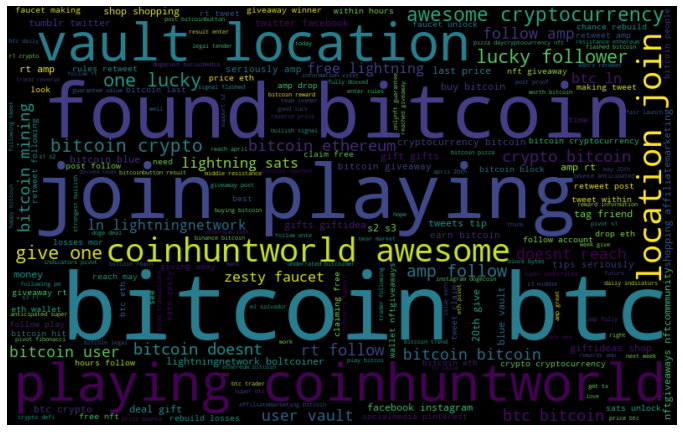

In [53]:
# all tokens illustrated in wordcloud positive sentiment
# bitcoin, will, found bitcoin, lucky, people, btc

normal_words =' '.join([text for text in tweets['text'][tweets['predicted_sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, background_color='black', random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

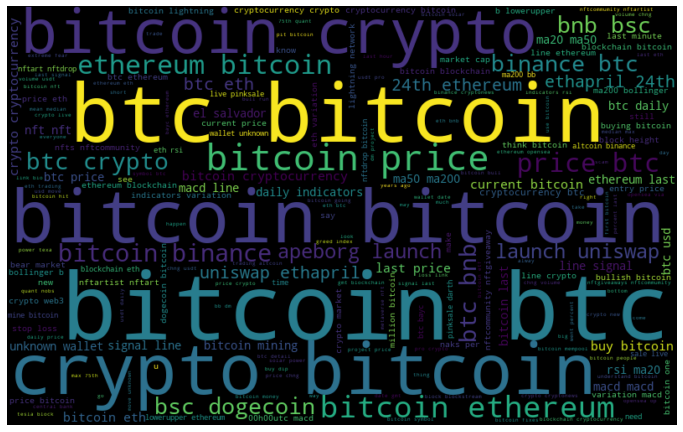

In [54]:
# all tokens illustrated in wordcloud but negative sentiment
# time, security, gate, bus, baggege, luggage, stuck, bag, car parking, passport control, staff

normal_words =' '.join([text for text in tweets['text'][tweets['predicted_sentiment'] == -1]])

wordcloud = WordCloud(width=800, background_color='black', height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [55]:
# Daily average aggregated
tweets_sentiment = tweets.groupby('Date')['predicted_compound'].mean().to_frame()
tweets_sentiment.reset_index(inplace=True)

In [56]:
tweets_sentiment

,Date,predicted_compound
0,2022-04-01,0.052430
1,2022-04-02,0.274100
2,2022-04-03,0.636900
3,2022-04-04,0.189849
4,2022-04-05,0.200008
...,...,...
90,2022-06-30,0.157233
91,2022-07-01,0.143505
92,2022-07-02,0.148051
93,2022-07-03,0.164367


In [57]:
btc_tweets = pd.merge(tweets_sentiment,btc,on='Date',how='left')

In [58]:
btc_tweets.head()

,Date,predicted_compound,Price,Open,High,Low,Vol.,Change %,price_change
0,2022-04-01,0.052430,"46,301.0","45,535.0","46,717.0","44,245.9",3.96K,1.68,Increase
1,2022-04-02,0.274100,"45,825.0","46,301.0","47,216.0","45,640.0",2.27K,-1.03,Decrease
2,2022-04-03,0.636900,"46,383.0","45,825.0","47,414.0","45,570.0",3.01K,1.22,Increase
3,2022-04-04,0.189849,"46,611.1","46,383.0","46,900.0","45,128.0",3.45K,0.49,Increase
4,2022-04-05,0.200008,"45,481.0","46,611.1","47,173.0","45,376.0",2.59K,-2.42,Decrease


### **Plots**

In [59]:
# Columns that we will plot
btc_tweets_copy=btc_tweets[btc_tweets['Date']>='2022-04-01']
btc_tweets_copy.loc[88,8] = 0

In [60]:
# Intreactive plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Line(x=btc_tweets_copy['Date'], y=btc_tweets_copy['Change %'], name="Price BTC"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=btc_tweets_copy['Date'], y=btc_tweets_copy['predicted_compound'], name="Sentiment"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Price_Change vs Sentiment Score for Twitter Data"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price Change BTC</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Sentiment Score</b>", secondary_y=True)

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [61]:
#create a function to get the sentiments labels
def getSentiment(compound):
  if compound >= 0.05:
    return 'Increase'
  elif compound <= -0.05:
      return 'Decrease'
  elif -0.05 < compound <0.05:
      return 'Neutral'

In [62]:
#create a column to store the sentiments labels
tweets_sentiment['Sentiment'] = tweets_sentiment['predicted_compound'].apply(getSentiment)
#show the data
tweets_sentiment.head(30000)

,Date,predicted_compound,Sentiment
0,2022-04-01,0.052430,Increase
1,2022-04-02,0.274100,Increase
2,2022-04-03,0.636900,Increase
3,2022-04-04,0.189849,Increase
4,2022-04-05,0.200008,Increase
...,...,...,...
90,2022-06-30,0.157233,Increase
91,2022-07-01,0.143505,Increase
92,2022-07-02,0.148051,Increase
93,2022-07-03,0.164367,Increase


### **Metrics**

The visual interpretation itself provides some valuable observations, however, certain numerical values should be calculated in a well-defined manner, which will be independent of the analysis performed. The very word quality is not fully specified, when creating such a system, you need to be able to decide what types of errors are acceptable and what the created model should not be able to afford. To check the effectiveness of the analysis, the sklearn classification_report and accuracy_score library methods were used

In [63]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [64]:
print(classification_report(btc_tweets['price_change'], tweets_sentiment['Sentiment']))

              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00        50
    Increase       0.44      0.91      0.60        43
     Neutral       0.00      0.00      0.00         2

    accuracy                           0.41        95
   macro avg       0.15      0.30      0.20        95
weighted avg       0.20      0.41      0.27        95



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [65]:
btc_tweets = pd.merge(tweets_sentiment,btc,on='Date',how='left')

In [66]:
# Creating new datasets
btc_corr = btc_tweets[["Date","Sentiment","price_change"]]

In [67]:
btc_tweets.reset_index(drop=True)

,Date,predicted_compound,Sentiment,Price,Open,High,Low,Vol.,Change %,price_change
0,2022-04-01,0.052430,Increase,"46,301.0","45,535.0","46,717.0","44,245.9",3.96K,1.68,Increase
1,2022-04-02,0.274100,Increase,"45,825.0","46,301.0","47,216.0","45,640.0",2.27K,-1.03,Decrease
2,2022-04-03,0.636900,Increase,"46,383.0","45,825.0","47,414.0","45,570.0",3.01K,1.22,Increase
3,2022-04-04,0.189849,Increase,"46,611.1","46,383.0","46,900.0","45,128.0",3.45K,0.49,Increase
4,2022-04-05,0.200008,Increase,"45,481.0","46,611.1","47,173.0","45,376.0",2.59K,-2.42,Decrease
...,...,...,...,...,...,...,...,...,...,...
90,2022-06-30,0.157233,Increase,"19,938.0","20,106.6","20,146.1","18,643.0",5.75K,-0.84,Decrease
91,2022-07-01,0.143505,Increase,"19,286.0","19,938.0","20,795.0","18,993.0",5.19K,-3.27,Decrease
92,2022-07-02,0.148051,Increase,"19,230.0","19,286.0","19,442.0","18,994.0",1.67K,-0.29,Decrease
93,2022-07-03,0.164367,Increase,"19,308.8","19,230.0","19,638.0","18,774.0",2.35K,0.41,Increase


In [68]:
btc_corr = btc_corr.reset_index(drop=True)
btc_corr

,Date,Sentiment,price_change
0,2022-04-01,Increase,Increase
1,2022-04-02,Increase,Decrease
2,2022-04-03,Increase,Increase
3,2022-04-04,Increase,Increase
4,2022-04-05,Increase,Decrease
...,...,...,...
90,2022-06-30,Increase,Decrease
91,2022-07-01,Increase,Decrease
92,2022-07-02,Increase,Decrease
93,2022-07-03,Increase,Increase


In [69]:
# Count of major fluctuations well predicted using Twitter
count = 0
for i in range(len(btc_corr)):
    if btc_corr["Sentiment"][i] == btc_corr["price_change"][i]:
        count += 1
count

39

In [70]:
# Percentage Accuracy
accuracy = count / len(btc_corr) * 100
round(accuracy,2)

41.05